In [2]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Flatten, ZeroPadding2D, Conv2D, MaxPooling2D, Activation, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
#splits the dataset into the three sets based on the specified ratio,
#which in this case is 60% training, 20% validation, and 20% test

!pip install split_folders
import splitfolders
splitfolders.ratio("../input/handwritten-math-symbols/dataset", output="./", seed=1337, ratio=(.6, .2, .2), group_prefix=None) # default values

Copying files: 10071 files [00:51, 196.05 files/s]


# Initialize ImageDataGenerator objects for training and validation sets, create generators with specified parameters.The images are resized to 224x224 pixels, converted to RGB color mode, and batched into groups of 24.

In [4]:
import os
NUM_CLASSES = len(os.listdir(r'./test'))

train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory(r'./train', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=24,
                                                 class_mode='categorical',
                                                 shuffle=True)

val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

val_generator=val_datagen.flow_from_directory(r'./val', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=24,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 6034 images belonging to 19 classes.
Found 2006 images belonging to 19 classes.


# Import pre-trained models, create sequential model with EfficientNetB6 and dense layer, print model summary.


In [12]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.efficientnet import EfficientNetB6

md = EfficientNetB6(weights='imagenet', include_top=False,  input_shape=(224, 224, 3), pooling='avg')

from keras.utils import plot_model
model = keras.models.Sequential([
    md,
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
# summarize layers
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb6 (Functional)  (None, 2304)             40960143  
                                                                 
 dense_2 (Dense)             (None, 19)                43795     
                                                                 
Total params: 41,003,938
Trainable params: 40,779,499
Non-trainable params: 224,439
_________________________________________________________________
None


# Define callbacks, compile model, and train on generator data with specified parameters and callbacks.


In [13]:
earlystop=EarlyStopping(patience=3) 
learning_rate_reduction=ReduceLROnPlateau(monitor='loss',patience=2,verbose=1,factor=0.1,min_lr=0.0000000001) 
callback=[learning_rate_reduction]

model.compile(optimizer=Adam(lr=0.00001),loss='categorical_crossentropy', metrics=['accuracy'])

step_size_train=train_generator.n//train_generator.batch_size
step_size_val=val_generator.n//val_generator.batch_size
history = model.fit_generator(generator=train_generator, steps_per_epoch=step_size_train, validation_data=val_generator, validation_steps=step_size_val, epochs=25, callbacks=callback)


Epoch 1/25


/tmp/ipykernel_32/4190429634.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator, steps_per_epoch=step_size_train, validation_data=val_generator, validation_steps=step_size_val, epochs=25, callbacks=callback)
2023-05-14 11:15:23.801533: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnetb6/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


251/251 [==============================] - 311s 970ms/step - loss: 2.2276 - accuracy: 0.5120 - val_loss: 2.9412 - val_accuracy: 0.0487 - lr: 1.0000e-05
Epoch 2/25
251/251 [==============================] - 239s 952ms/step - loss: 0.8864 - accuracy: 0.8830 - val_loss: 1.4781 - val_accuracy: 0.8188 - lr: 1.0000e-05
Epoch 3/25
251/251 [==============================] - 243s 969ms/step - loss: 0.3437 - accuracy: 0.9499 - val_loss: 0.6624 - val_accuracy: 0.9458 - lr: 1.0000e-05
Epoch 4/25
251/251 [==============================] - 243s 969ms/step - loss: 0.1793 - accuracy: 0.9735 - val_loss: 0.1932 - val_accuracy: 0.9814 - lr: 1.0000e-05
Epoch 5/25
251/251 [==============================] - 240s 957ms/step - loss: 0.1245 - accuracy: 0.9767 - val_loss: 0.0689 - val_accuracy: 0.9895 - lr: 1.0000e-05
Epoch 6/25
251/251 [==============================] - 239s 953ms/step - loss: 0.0813 - accuracy: 0.9849 - val_loss: 0.0678 - val_accuracy: 0.9885 - lr: 1.0000e-05
Epoch 7/25
251/251 [=============

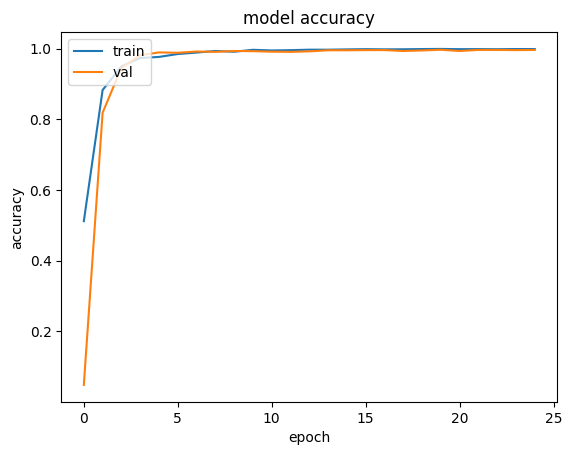

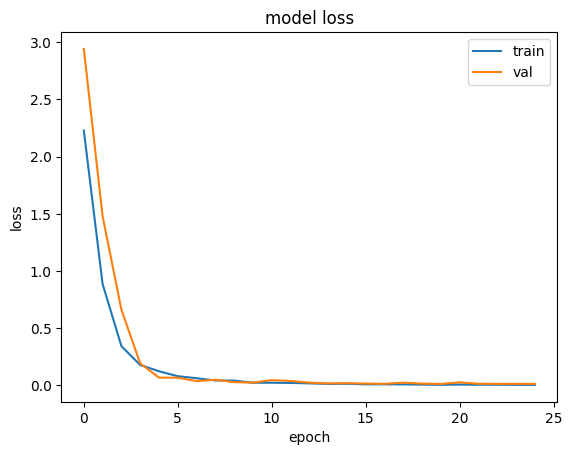

In [15]:
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

**Load test data and predict using the trained model,Predict using the model,Extract predicted class indices and map them to class labels,Create a dataframe to store the filenames and predictions******

Found 2031 images belonging to 19 classes.


/tmp/ipykernel_32/2706580789.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred=model.predict_generator(test_generator,verbose=1,steps=test_generator.n/batch_size)


84/84 [==============================] - 22s 211ms/step
            Filename Predictions
0        0/12703.jpg           0
1        0/13230.jpg           0
2        0/13609.jpg           0
3        0/14696.jpg           0
4        0/15747.jpg           0
...              ...         ...
2026  z/uiPMWPLg.png           z
2027  z/vhqTi7m7.png           z
2028  z/w9WIEnfK.png           z
2029  z/wfancEOV.png           z
2030  z/yySeSeTY.png           z

[2031 rows x 2 columns]
2024 7
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       119
           1       1.00      0.98      0.99       113
           2       0.99      0.99      0.99        88
           3       0.99      1.00      1.00       109
           4       1.00      0.99      1.00       106
           5       1.00      0.99      0.99        88
           6       0.98      1.00      0.99       117
           7       0.98      1.00      0.99       108
           8       1.00      

<AxesSubplot: >

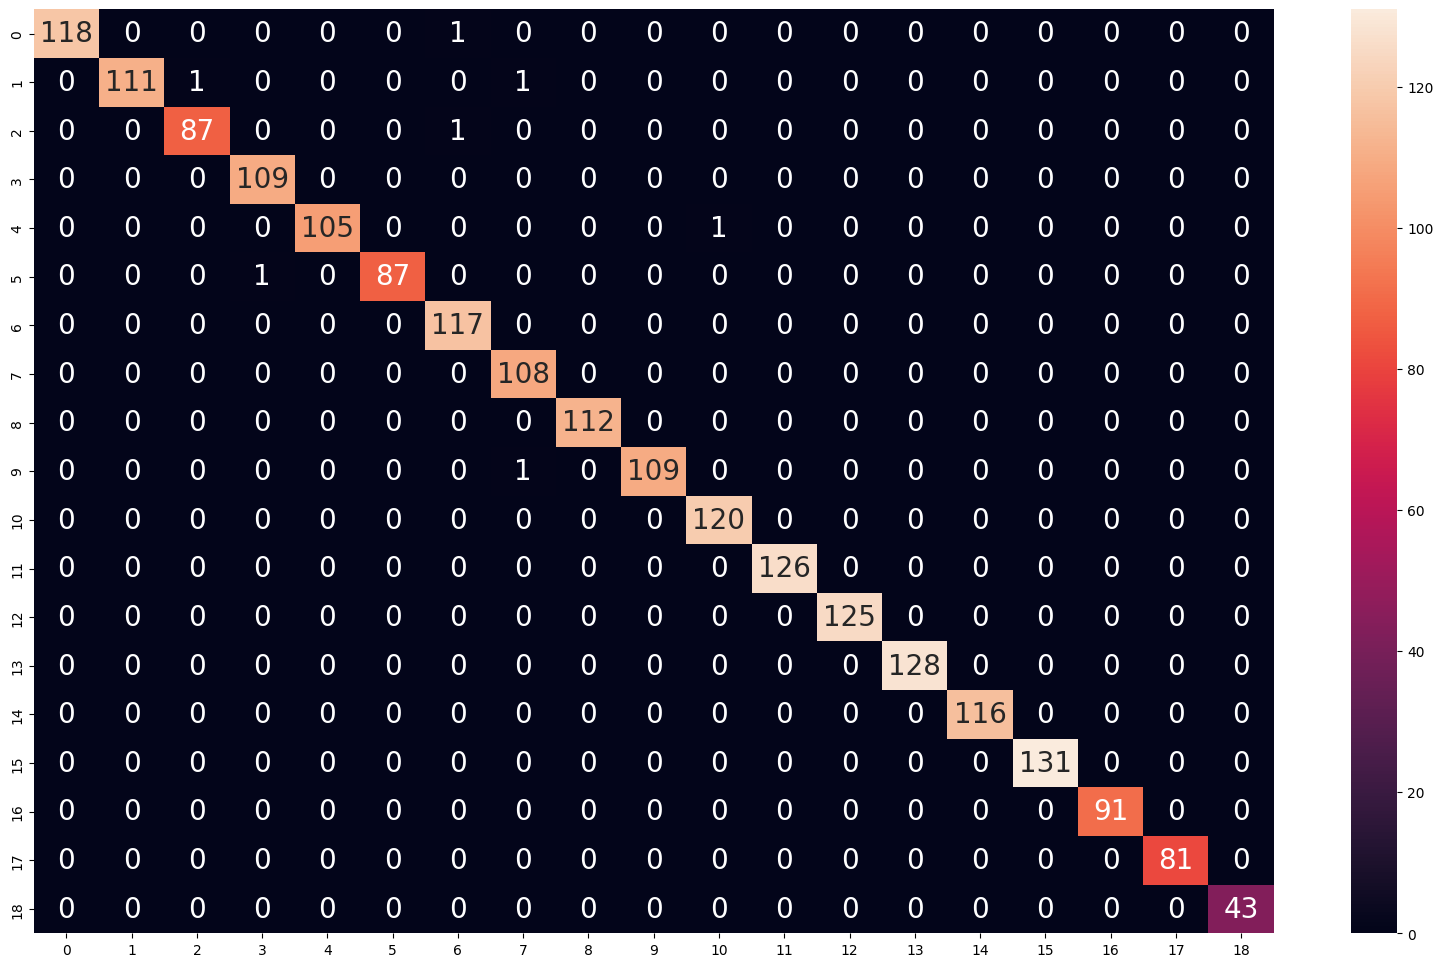

In [16]:
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
batch_size=24
pred_dir = r'./test'
test_generator = test_datagen.flow_from_directory(
    directory=pred_dir,
    target_size=(224,224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)
#test_generator.reset() 
pred=model.predict_generator(test_generator,verbose=1,steps=test_generator.n/batch_size)

predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
print(results)


import pandas as pd
t_counter = 0
f_counter = 0

file_arr = []
pred_arr = []

for index, row in results.iterrows():
    #print(row['Filename'].split('/')[0], row['Predictions'])
    file_arr.append(row['Filename'].split('/')[0])
    pred_arr.append(row['Predictions'])
    if row['Filename'].split('/')[0] == row['Predictions']:
        t_counter = t_counter + 1
    else:
        f_counter = f_counter + 1
print(t_counter, f_counter)

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
test_y = labelencoder.fit_transform(file_arr)
pred_y = labelencoder.fit_transform(pred_arr)
test_y_or = test_y
pred_y_or = pred_y

from keras.utils import np_utils
test_y = np_utils.to_categorical(test_y, NUM_CLASSES)
pred_y = np_utils.to_categorical(pred_y, NUM_CLASSES)
from sklearn.metrics import classification_report
print(classification_report(test_y, pred_y))

from sklearn.metrics import accuracy_score
score = accuracy_score(test_y, pred_y)
print(score*100)

from sklearn.metrics import confusion_matrix
c=confusion_matrix(test_y_or, pred_y_or)
x = c.diagonal()/c.sum(axis=1)
for i in range(len(x)):
    print('Class ', i, ' Accuracy: ', x[i])
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (20,12))
sns.heatmap(c, annot=True, annot_kws={"size": 20}, fmt='d')

In [17]:
original = np.argmax(test_y,axis=1)

pred2 = pred
for i in range(len(pred2)):
    pred2[i][predicted_class_indices[i]]=0

predicted_class_indices2 = np.argmax(pred,axis=1)

pred3 = pred2
for i in range(len(pred3)):
    pred3[i][predicted_class_indices2[i]]=0

predicted_class_indices3 = np.argmax(pred2,axis=1)

predicted_class_indices, predicted_class_indices2, predicted_class_indices3, original

(array([ 0,  0,  0, ..., 18, 18, 18]),
 array([ 8, 18,  6, ..., 16, 16,  7]),
 array([ 9,  6,  3, ...,  2,  8, 14]),
 array([ 0,  0,  0, ..., 18, 18, 18]))

In [18]:
top2 = []
for i in range(len(original)):
    if predicted_class_indices[i]==original[i] or predicted_class_indices2[i]==original[i]:
        top2.append(original[i])
    else:
        top2.append(predicted_class_indices[i])
top2 = np.array(top2)

top3 = []
for i in range(len(original)):
    if predicted_class_indices[i]==original[i] or predicted_class_indices2[i]==original[i] or predicted_class_indices3[i]==original[i]:
        top3.append(original[i])
    else:
        top3.append(predicted_class_indices[i])
top3 = np.array(top3)

top2, top3

(array([ 0,  0,  0, ..., 18, 18, 18]), array([ 0,  0,  0, ..., 18, 18, 18]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       119
           1       1.00      1.00      1.00       113
           2       1.00      0.99      0.99        88
           3       1.00      1.00      1.00       109
           4       1.00      0.99      1.00       106
           5       1.00      1.00      1.00        88
           6       0.99      1.00      1.00       117
           7       1.00      1.00      1.00       108
           8       1.00      1.00      1.00       112
           9       1.00      1.00      1.00       110
          10       0.99      1.00      1.00       120
          11       1.00      1.00      1.00       126
          12       1.00      1.00      1.00       125
          13       1.00      1.00      1.00       128
          14       1.00      1.00      1.00       116
          15       1.00      1.00      1.00       131
          16       1.00      1.00      1.00        91
          17       1.00    

<AxesSubplot: >

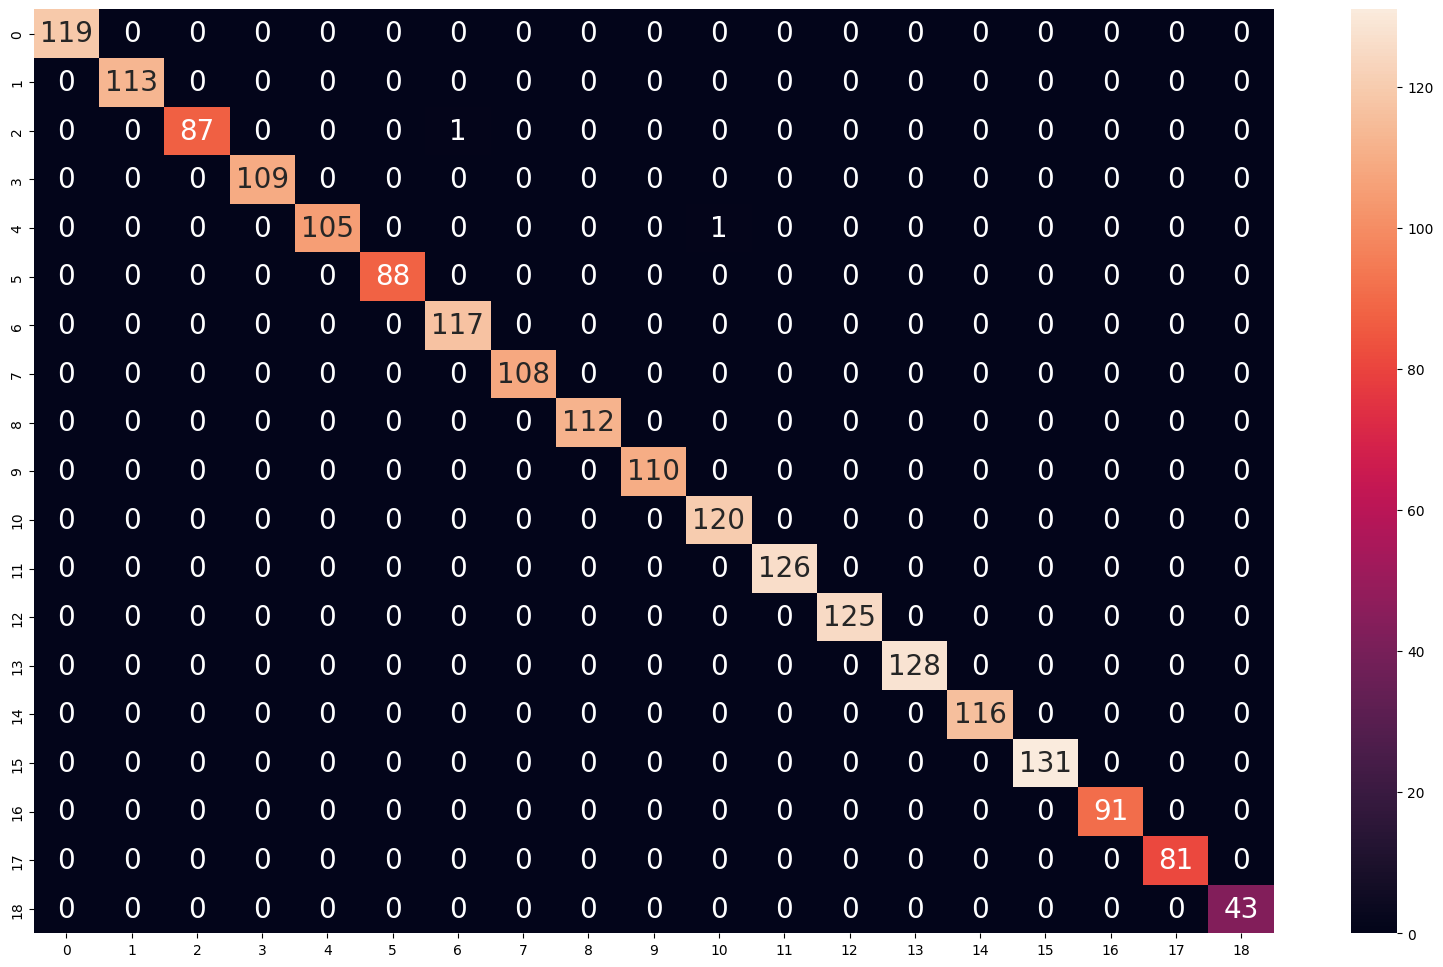

In [19]:
pred_y = top2
test_y = original
from keras.utils import np_utils
#test_y = np_utils.to_categorical(test_y, NUM_CLASSES)
#pred_y = np_utils.to_categorical(pred_y, NUM_CLASSES)
from sklearn.metrics import classification_report
print(classification_report(test_y, pred_y))

from sklearn.metrics import accuracy_score
score = accuracy_score(test_y, pred_y)
print(score*100)

from sklearn.metrics import confusion_matrix
c=confusion_matrix(test_y, pred_y)
x = c.diagonal()/c.sum(axis=1)
for i in range(len(x)):
    print('Class ', i, ' Accuracy: ', x[i])
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (20,12))
sns.heatmap(c, annot=True, annot_kws={"size": 20}, fmt='d')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       119
           1       1.00      1.00      1.00       113
           2       1.00      0.99      0.99        88
           3       1.00      1.00      1.00       109
           4       1.00      1.00      1.00       106
           5       1.00      1.00      1.00        88
           6       0.99      1.00      1.00       117
           7       1.00      1.00      1.00       108
           8       1.00      1.00      1.00       112
           9       1.00      1.00      1.00       110
          10       1.00      1.00      1.00       120
          11       1.00      1.00      1.00       126
          12       1.00      1.00      1.00       125
          13       1.00      1.00      1.00       128
          14       1.00      1.00      1.00       116
          15       1.00      1.00      1.00       131
          16       1.00      1.00      1.00        91
          17       1.00    

<AxesSubplot: >

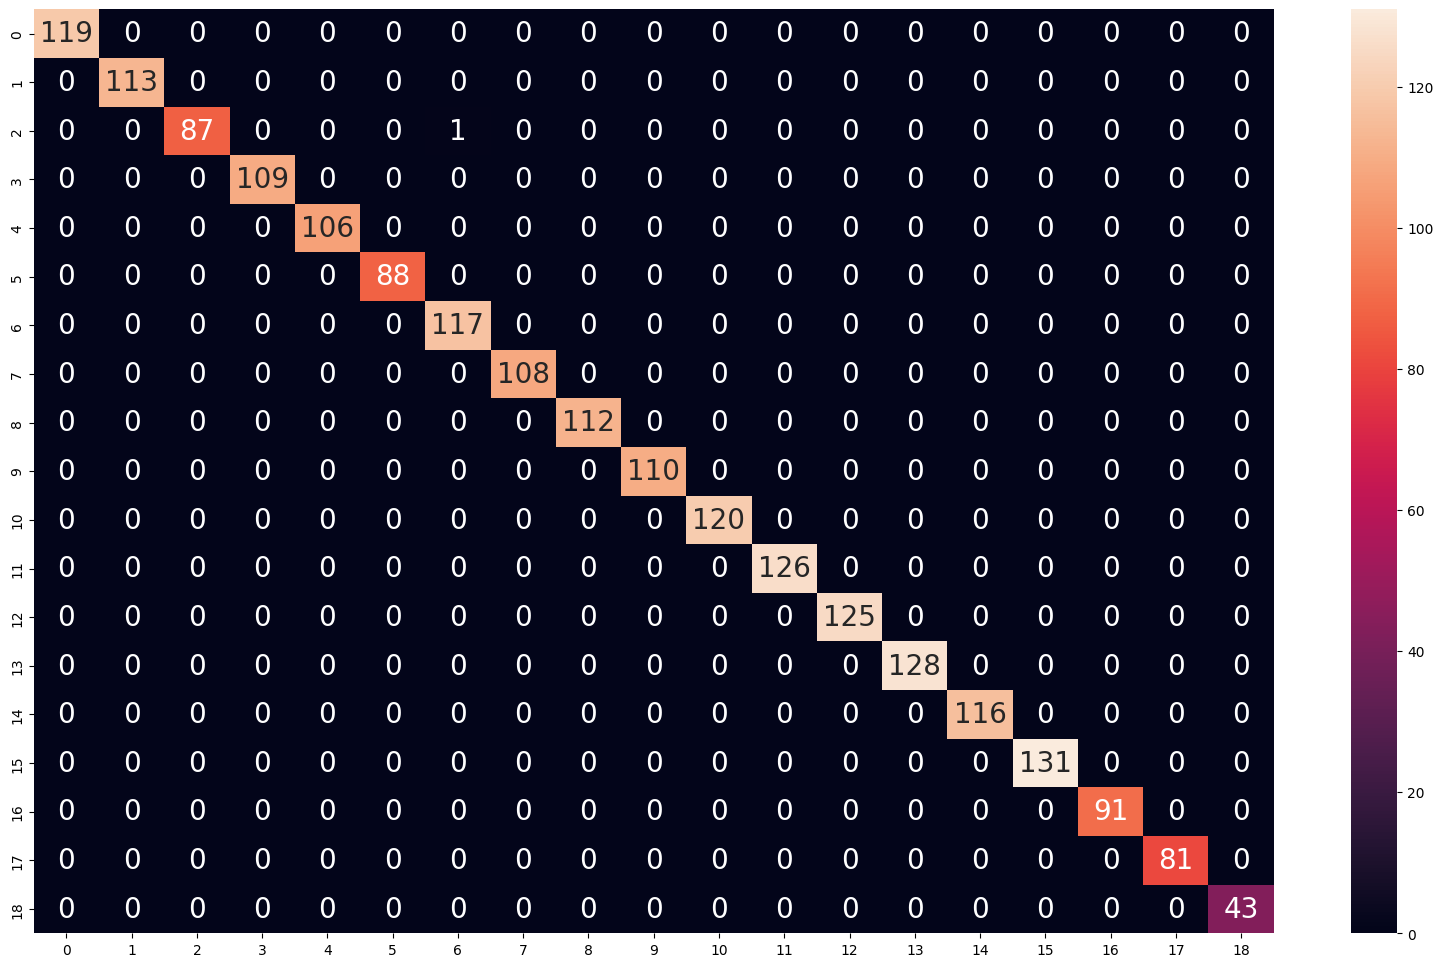

In [20]:
pred_y = top3
test_y = original
from keras.utils import np_utils
#test_y = np_utils.to_categorical(test_y, NUM_CLASSES)
#pred_y = np_utils.to_categorical(pred_y, NUM_CLASSES)
from sklearn.metrics import classification_report
print(classification_report(test_y, pred_y))

from sklearn.metrics import accuracy_score
score = accuracy_score(test_y, pred_y)
print(score*100)

from sklearn.metrics import confusion_matrix
c=confusion_matrix(test_y, pred_y)
x = c.diagonal()/c.sum(axis=1)
for i in range(len(x)):
    print('Class ', i, ' Accuracy: ', x[i])
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (20,12))
sns.heatmap(c, annot=True, annot_kws={"size": 20}, fmt='d')

1/1 [==============================] - 0s 71ms/step


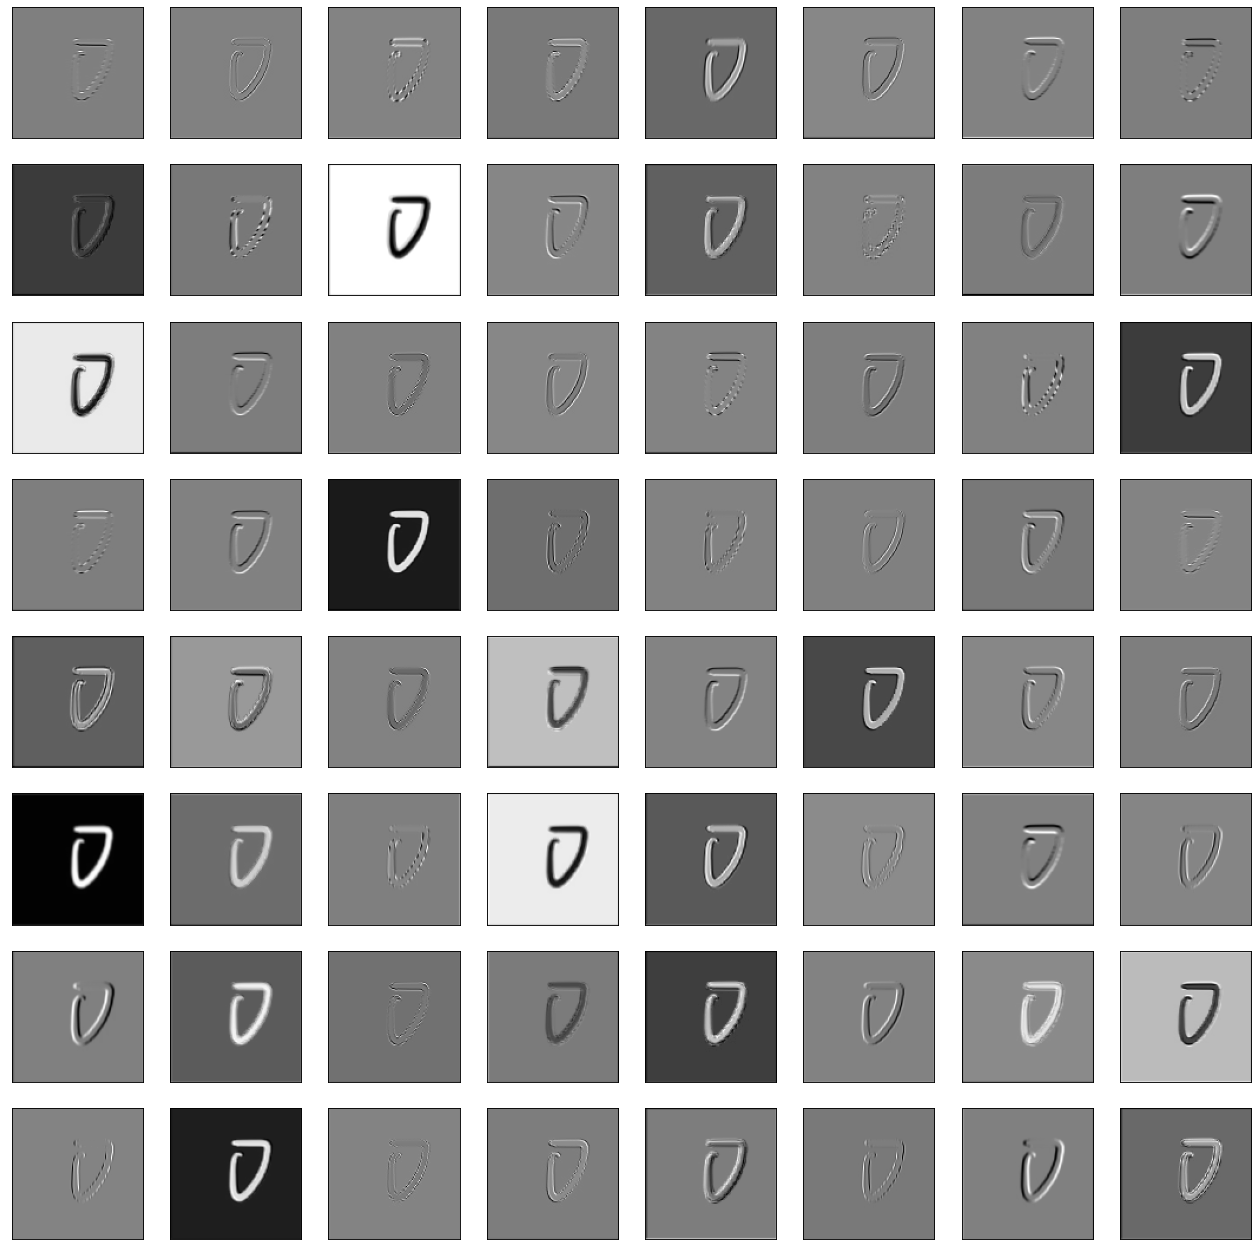

In [24]:
# plot feature map of first conv layer for given image
from keras.applications.densenet import DenseNet201
from keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
pyplot.figure(figsize=(20, 20), dpi=80)
# load the model
model = DenseNet201()
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[2].output)
#model.summary()
# load the image with the required shape
img = load_img('../input/handwritten-math-symbols/dataset/0/10014.jpg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the densenet)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
#print(feature_maps)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
pyplot.show()


1/1 [==============================] - 0s 50ms/step


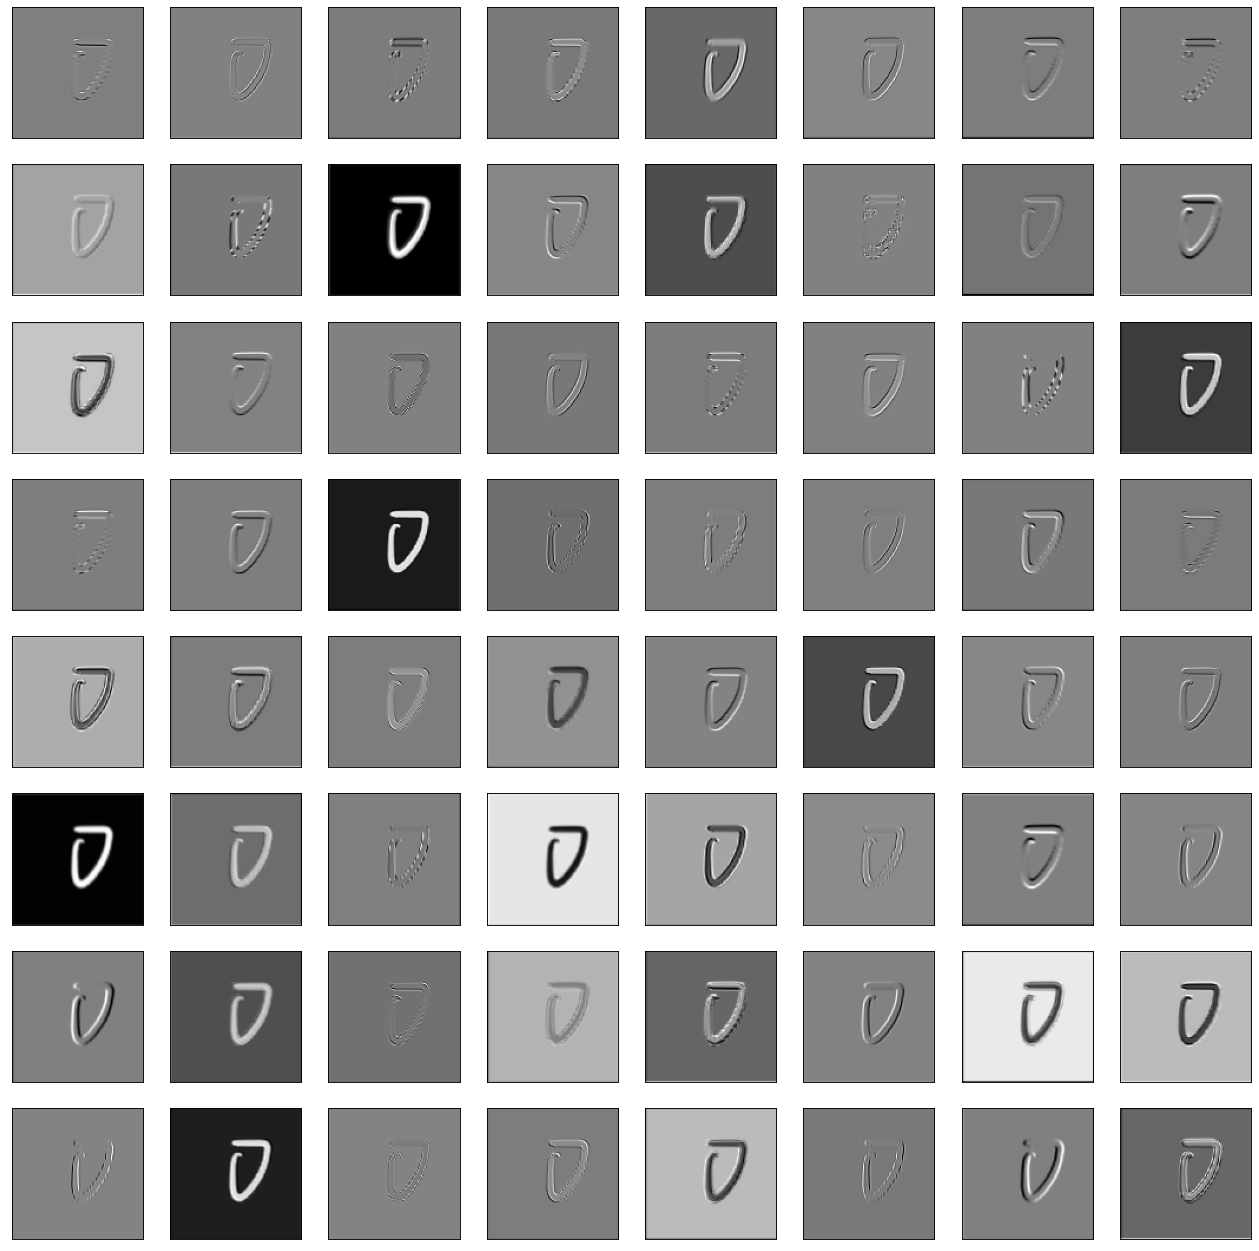

In [27]:
# plot feature map of first conv layer for given image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array # Updated import statement
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
pyplot.figure(figsize=(20, 20), dpi=80)
# load the model
model = DenseNet201()
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[3].output)
#model.summary()
# load the image with the required shape
img = load_img('../input/handwritten-math-symbols/dataset/0/10014.jpg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
#print(feature_maps)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
pyplot.show()
